## 1. Pobieranie zbioru danych

In [97]:
!pip install --user kaggle

In [98]:
!kaggle datasets download -d kamilpytlak/personal-key-indicators-of-heart-disease/

personal-key-indicators-of-heart-disease.zip: Skipping, found more recently modified local copy (use --force to force download)


In [99]:
#!unzip -o personal-key-indicators-of-heart-disease.zip #nie działa na Windowsie więc korzystam z modułu zipfile

In [100]:
import zipfile
with zipfile.ZipFile("personal-key-indicators-of-heart-disease.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset_extracted")

In [50]:
import pandas as pd
# W pobranym zbiorze danych jest kilka podzbiorów więc celowo otwieram ten z NaN, żeby manualnie go oczyścić dla praktyki
df = pd.read_csv("dataset_extracted/2022/heart_2022_with_nans.csv")

## Przeglądanie nieoczyszczonego datasetu

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

In [52]:
df.head()

State     Sex GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
0  Alabama  Female     Very good                 0.0               0.0   
1  Alabama  Female     Excellent                 0.0               0.0   
2  Alabama  Female     Very good                 2.0               3.0   
3  Alabama  Female     Excellent                 0.0               0.0   
4  Alabama  Female          Fair                 2.0               0.0   

                                     LastCheckupTime PhysicalActivities  \
0  Within past year (anytime less than 12 months ...                 No   
1                                                NaN                 No   
2  Within past year (anytime less than 12 months ...                Yes   
3  Within past year (anytime less than 12 months ...                Yes   
4  Within past year (anytime less than 12 months ...                Yes   

   SleepHours RemovedTeeth HadHeartAttack  ... HeightInMeters  \
0         8.0          NaN             No  ...            NaN   
1         6.0          NaN             No  ...           1.60   
2         5.0          NaN             No  ...           1.57   
3         7.0          NaN             No  ...           1.65   
4         9.0          NaN             No  ...           1.57   

  WeightInKilograms    BMI AlcoholDrinkers HIVTesting FluVaxLast12  \
0               NaN    NaN              No         No          Yes   
1             68.04  26.57              No         No           No   
2             63.50  25.61              No         No           No   
3             63.50  23.30              No         No          Yes   
4             53.98  21.77             Yes         No           No   

  PneumoVaxEver                                  TetanusLast10Tdap  \
0            No  Yes, received tetanus shot but not sure what type   
1            No  No, did not receive any tetanus shot in the pa...   
2            No                                                NaN   
3           Yes  No, did not receive any tetanus shot in the pa...   
4           Yes  No, did not receive any tetanus shot in the pa...   

  HighRiskLastYear CovidPos  
0               No       No  
1               No       No  
2               No      Yes  
3               No       No  
4               No       No  

[5 rows x 40 columns]

In [53]:
df.describe()

PhysicalHealthDays  MentalHealthDays     SleepHours  HeightInMeters  \
count       434205.000000     436065.000000  439679.000000   416480.000000   
mean             4.347919          4.382649       7.022983        1.702691   
std              8.688912          8.387475       1.502425        0.107177   
min              0.000000          0.000000       1.000000        0.910000   
25%              0.000000          0.000000       6.000000        1.630000   
50%              0.000000          0.000000       7.000000        1.700000   
75%              3.000000          5.000000       8.000000        1.780000   
max             30.000000         30.000000      24.000000        2.410000   

       WeightInKilograms            BMI  
count      403054.000000  396326.000000  
mean           83.074470      28.529842  
std            21.448173       6.554889  
min            22.680000      12.020000  
25%            68.040000      24.130000  
50%            80.740000      27.440000  
75%            95.250000      31.750000  
max           292.570000      99.640000

#### Tylko 6 kolumn jest numeryczne na razie więc wiele statystyk nie zostaje wyświetlonych w tym podsumowaniu

#### Zbiór danych jest niezbalansowany, zmienna którą chcemy przewidzieć w znacznej większości przypadków wynosi 0:

<AxesSubplot:ylabel='count'>

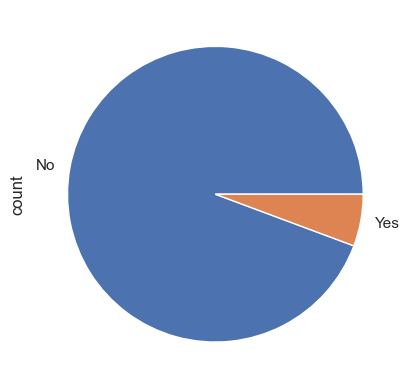

In [54]:
df["HadHeartAttack"].value_counts().plot(kind="pie")

In [55]:
df["HadHeartAttack"].value_counts()

HadHeartAttack
No     416959
Yes     25108
Name: count, dtype: int64

## 2. Podział na podzbiory (train / dev / test - 8:1:1)) i oversampling

In [56]:
from sklearn.model_selection import train_test_split
#Funkcji z sklearn musimy użyć dwukrotnie, bo dzieli tylko na dwa podzbiory
train, test_and_valid = train_test_split(df, test_size=0.2) #0.8 train, 0.2 test&valid

test, valid = train_test_split(test_and_valid, test_size=0.5) #0.1 test, 0.1 valid

In [57]:
train["HadHeartAttack"].value_counts()

HadHeartAttack
No     333640
Yes     20032
Name: count, dtype: int64

Zbiór treningowy jest nadal niezbalansowany więc zrobię prosty oversampling przez kopiowanie mniejszej klasy aż będą prawie równe

In [58]:
def oversample(dataset):
    num_true = len(dataset[dataset["HadHeartAttack"]=="Yes"])
    num_false = len(dataset[dataset["HadHeartAttack"]=="No"])
    num_oversampling_steps = num_false//num_true
    oversampled = dataset.copy()
    for x in range(num_oversampling_steps):
        oversampled = pd.concat([oversampled, dataset[dataset["HadHeartAttack"]=="Yes"]], ignore_index=True)
    return oversampled

In [59]:
train = oversample(train)

<AxesSubplot:ylabel='count'>

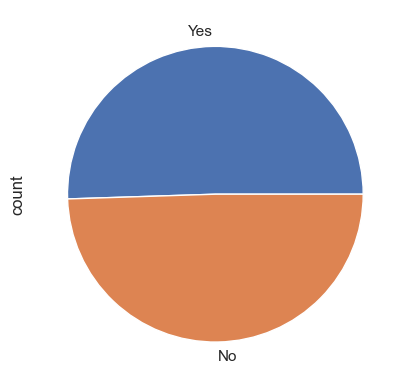

In [60]:
train["HadHeartAttack"].value_counts().plot(kind="pie")

<AxesSubplot:ylabel='count'>

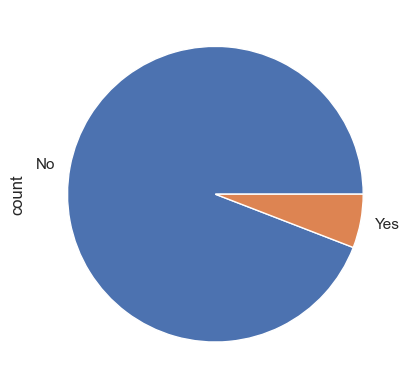

In [61]:
test["HadHeartAttack"].value_counts().plot(kind="pie")

<AxesSubplot:ylabel='count'>

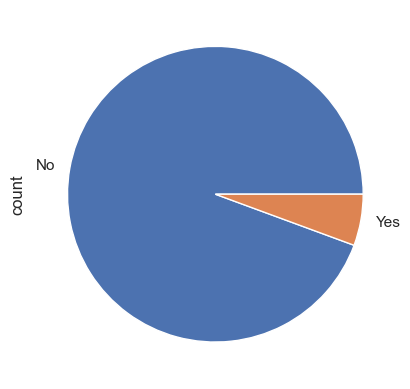

In [62]:
valid["HadHeartAttack"].value_counts().plot(kind="pie")

Proporcje osób palących / niepalących w pierwotnym zbiorze danych:

<AxesSubplot:ylabel='count'>

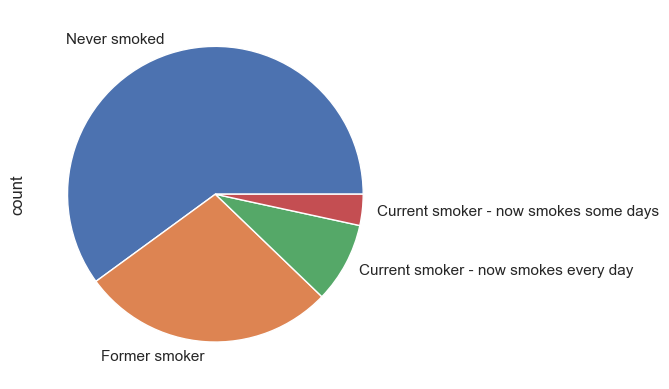

In [63]:
df["SmokerStatus"].value_counts().plot(kind="pie")

<AxesSubplot:ylabel='count'>

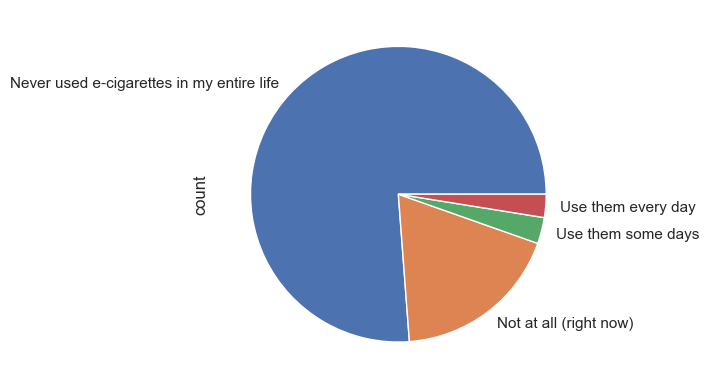

In [64]:
df["ECigaretteUsage"].value_counts().plot(kind="pie")

### Statystyki covidowe

<AxesSubplot:ylabel='count'>

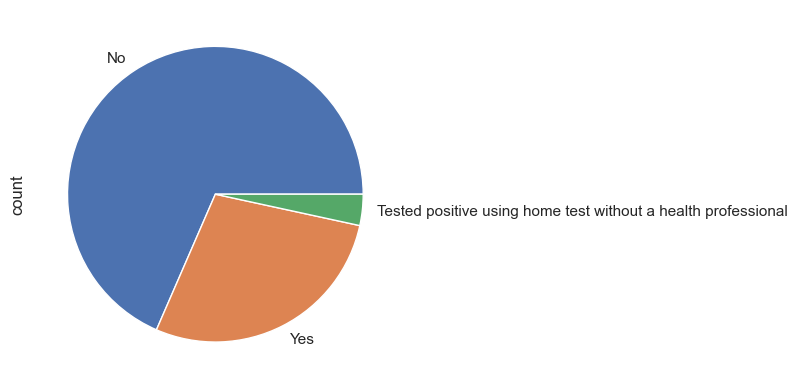

In [65]:
df["CovidPos"].value_counts().plot(kind="pie")

## Normalizacja część 1 - zamiana na kolumny liczbowe i kategoryczne

Kolumny zawierające stan zdrowia i podobne cechy opisane w sposób "poor/fair/good/excellent" etc. starałem się zamienić na liczbowe w sposób sensowny, rosnący względem pozytywnego aspektu tego czynnika zdrowotnego. Podobnie z tym jak często dana osoba paliła.
Część kolumn zamieniłem na kategoryczne
Kolumnę płci zamieniłem na numeryczną w celu późniejszego wykorzystania przez model, choć mialem wątpliwości co do robienia tego pod względem poprawności politycznej


In [66]:
df["Sex"].unique()

array(['Female', 'Male'], dtype=object)

In [67]:
df["GeneralHealth"].unique()

array(['Very good', 'Excellent', 'Fair', 'Poor', 'Good', nan],
      dtype=object)

In [68]:
health_map = {
    "Excellent": 5,
    "Very good": 4,
    "Good": 3,
    "Fair": 2,
    "Poor": 1
}

In [69]:
for col in df:
    print(f"{col}:")
    print(df[col].unique())

State:
['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Guam' 'Puerto Rico'
 'Virgin Islands']
Sex:
['Female' 'Male']
GeneralHealth:
['Very good' 'Excellent' 'Fair' 'Poor' 'Good' nan]
PhysicalHealthDays:
[ 0.  2.  1.  8.  5. 30.  4. 23. 14. nan 15.  3. 10.  7. 25.  6. 21. 20.
 29. 16.  9. 27. 28. 12. 13. 11. 26. 17. 24. 19. 18. 22.]
MentalHealthDays:
[ 0.  3.  9.  5. 15. 20. 14. 10. 18.  1. nan  2. 30.  4.  6.  7. 25.  8.
 22. 29. 27. 21. 1

In [70]:
from collections import defaultdict
def normalize_dataset(dataset):
    dataset["GeneralHealth"] = dataset["GeneralHealth"].map(defaultdict(lambda: float('NaN'), health_map), na_action='ignore')
    dataset["Sex"] = dataset["Sex"].map({"Female":0,"Male":1}).astype(float) #Zamiana z kolumn tekstowych na numeryczne
    dataset.rename(columns ={"Sex":"Male"},inplace=True)
    dataset["State"] = dataset["State"].astype('category')
    dataset["PhysicalHealthDays"].astype(float)
    dataset["MentalHealthDays"].astype(float)
    dataset["LastCheckupTime"] = dataset["LastCheckupTime"].fillna("Unknown").astype('category') # Potem korzystam z fillna-->median ale nie działa to na kolumnach kategorycznych więc wykonuję to przed konwersją
    dataset["PhysicalActivities"]= dataset["PhysicalActivities"].map({"No":0,"Yes":1})
    dataset["SleepHours"].astype(float)
    dataset["RemovedTeeth"] = dataset["RemovedTeeth"].map(defaultdict(lambda: float('NaN'), {"None of them":0,"1 to 5":1, "6 or more, but not all":2, "All":3}), na_action='ignore')
    dataset["HadHeartAttack"]= dataset["HadHeartAttack"].map({"No":0,"Yes":1})
    dataset["HadAngina"]= dataset["HadAngina"].map({"No":0,"Yes":1})
    dataset["HadStroke"]= dataset["HadStroke"].map({"No":0,"Yes":1})
    dataset["HadAsthma"]= dataset["HadAsthma"].map({"No":0,"Yes":1})
    dataset["HadSkinCancer"]= dataset["HadSkinCancer"].map({"No":0,"Yes":1})
    dataset["HadCOPD"]= dataset["HadCOPD"].map({"No":0,"Yes":1})
    dataset["HadDepressiveDisorder"]= dataset["HadDepressiveDisorder"].map({"No":0,"Yes":1})
    dataset["HadKidneyDisease"]= dataset["HadKidneyDisease"].map({"No":0,"Yes":1})
    dataset["HadArthritis"]= dataset["HadArthritis"].map({"No":0,"Yes":1})
    dataset["HadDiabetes"]= dataset["HadDiabetes"].map({"No":0,"Yes, but only during pregnancy (female)":1,"No, pre-diabetes or borderline diabetes":2,"Yes":3})

    dataset["DeafOrHardOfHearing"]= dataset["DeafOrHardOfHearing"].map({"No":0,"Yes":1})
    dataset["BlindOrVisionDifficulty"]= dataset["BlindOrVisionDifficulty"].map({"No":0,"Yes":1})
    dataset["DifficultyConcentrating"]= dataset["DifficultyConcentrating"].map({"No":0,"Yes":1})
    dataset["DifficultyWalking"]= dataset["DifficultyWalking"].map({"No":0,"Yes":1})
    dataset["DifficultyDressingBathing"]= dataset["DifficultyDressingBathing"].map({"No":0,"Yes":1})
    dataset["DifficultyErrands"]= dataset["DifficultyErrands"].map({"No":0,"Yes":1})
    dataset["SmokerStatus"]= dataset["SmokerStatus"].map({"Never smoked":0,"Current smoker - now smokes some days":1,"Former smoker":2,"Current smoker - now smokes every day":3})
    dataset["ECigaretteUsage"]= dataset["ECigaretteUsage"].map({"Never used e-cigarettes in my entire life":0,"Not at all (right now)":1,"Use them some days":2,"Use them every day":3})
    dataset["ChestScan"]= dataset["ChestScan"].map({"No":0,"Yes":1})
    dataset["RaceEthnicityCategory"] = dataset["RaceEthnicityCategory"].fillna("Unknown").astype('category')
    dataset["AgeCategory"] = dataset["AgeCategory"].fillna("Unknown").astype('category')
    dataset["HeightInMeters"] = dataset["HeightInMeters"].astype(float)
    dataset["WeightInKilograms"] = dataset["WeightInKilograms"].astype(float)
    dataset["BMI"] = dataset["BMI"].astype(float)
    dataset["AlcoholDrinkers"]= dataset["AlcoholDrinkers"].map({"No":0,"Yes":1})
    dataset["HIVTesting"]= dataset["HIVTesting"].map({"No":0,"Yes":1})
    dataset["FluVaxLast12"]= dataset["FluVaxLast12"].map({"No":0,"Yes":1})
    dataset["PneumoVaxEver"]= dataset["PneumoVaxEver"].map({"No":0,"Yes":1})
    dataset["TetanusLast10Tdap"]= dataset["TetanusLast10Tdap"].apply(lambda x: float('NaN') if type(x)!=str else 1.0 if 'Yes,' in x else 1.0 if 'No,' in x else float('NaN'))
    dataset["HighRiskLastYear"]= dataset["HighRiskLastYear"].map({"No":0,"Yes":1})
    dataset["CovidPos"]= dataset["CovidPos"].map({"No":0,"Yes":1})

### Zbiór test przed zmianą typu danych

In [71]:
test.head()

State     Sex GeneralHealth  PhysicalHealthDays  \
276058    New York    Male          Good                 2.0   
189605    Michigan  Female          Fair                20.0   
59234     Delaware  Female     Very good                 0.0   
255322  New Mexico    Male          Good                 0.0   
226504     Montana  Female     Very good                 6.0   

        MentalHealthDays                                    LastCheckupTime  \
276058               0.0  Within past 2 years (1 year but less than 2 ye...   
189605              15.0  Within past year (anytime less than 12 months ...   
59234                0.0  Within past year (anytime less than 12 months ...   
255322               0.0                                5 or more years ago   
226504               0.0  Within past year (anytime less than 12 months ...   

       PhysicalActivities  SleepHours  RemovedTeeth HadHeartAttack  ...  \
276058                NaN         7.0  None of them             No  ...   
189605                Yes         5.0           All             No  ...   
59234                 Yes         6.0  None of them             No  ...   
255322                Yes         6.0  None of them             No  ...   
226504                Yes         8.0  None of them             No  ...   

       HeightInMeters WeightInKilograms    BMI AlcoholDrinkers HIVTesting  \
276058           1.55               NaN    NaN              No         No   
189605           1.68             70.31  25.02              No        NaN   
59234            1.50             64.41  28.68              No         No   
255322            NaN               NaN    NaN             NaN        NaN   
226504           1.73             90.72  30.41             Yes         No   

       FluVaxLast12 PneumoVaxEver  \
276058           No           NaN   
189605          Yes           Yes   
59234           Yes           NaN   
255322          NaN           NaN   
226504           No           Yes   

                                        TetanusLast10Tdap HighRiskLastYear  \
276058  No, did not receive any tetanus shot in the pa...               No   
189605                                                NaN               No   
59234   No, did not receive any tetanus shot in the pa...               No   
255322                                                NaN              NaN   
226504                                                NaN               No   

       CovidPos  
276058       No  
189605       No  
59234        No  
255322      NaN  
226504      Yes  

[5 rows x 40 columns]

## Zbiór test po zmianie typu danych

In [72]:
normalize_dataset(test)
test.head()

State  Male  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
276058    New York   1.0            3.0                 2.0               0.0   
189605    Michigan   0.0            2.0                20.0              15.0   
59234     Delaware   0.0            4.0                 0.0               0.0   
255322  New Mexico   1.0            3.0                 0.0               0.0   
226504     Montana   0.0            4.0                 6.0               0.0   

                                          LastCheckupTime  PhysicalActivities  \
276058  Within past 2 years (1 year but less than 2 ye...                 NaN   
189605  Within past year (anytime less than 12 months ...                 1.0   
59234   Within past year (anytime less than 12 months ...                 1.0   
255322                                5 or more years ago                 1.0   
226504  Within past year (anytime less than 12 months ...                 1.0   

        SleepHours  RemovedTeeth  HadHeartAttack  ...  HeightInMeters  \
276058         7.0           0.0             0.0  ...            1.55   
189605         5.0           3.0             0.0  ...            1.68   
59234          6.0           0.0             0.0  ...            1.50   
255322         6.0           0.0             0.0  ...             NaN   
226504         8.0           0.0             0.0  ...            1.73   

        WeightInKilograms    BMI  AlcoholDrinkers  HIVTesting  FluVaxLast12  \
276058                NaN    NaN              0.0         0.0           0.0   
189605              70.31  25.02              0.0         NaN           1.0   
59234               64.41  28.68              0.0         0.0           1.0   
255322                NaN    NaN              NaN         NaN           NaN   
226504              90.72  30.41              1.0         0.0           0.0   

        PneumoVaxEver  TetanusLast10Tdap  HighRiskLastYear  CovidPos  
276058            NaN                1.0               0.0       0.0  
189605            1.0                NaN               0.0       0.0  
59234             NaN                1.0               0.0       0.0  
255322            NaN                NaN               NaN       NaN  
226504            1.0                NaN               0.0       1.0  

[5 rows x 40 columns]

In [73]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44513 entries, 276058 to 196692
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   State                      44513 non-null  category
 1   Male                       44513 non-null  float64 
 2   GeneralHealth              44380 non-null  float64 
 3   PhysicalHealthDays         43374 non-null  float64 
 4   MentalHealthDays           43620 non-null  float64 
 5   LastCheckupTime            44513 non-null  category
 6   PhysicalActivities         44383 non-null  float64 
 7   SleepHours                 43982 non-null  float64 
 8   RemovedTeeth               43364 non-null  float64 
 9   HadHeartAttack             44220 non-null  float64 
 10  HadAngina                  44117 non-null  float64 
 11  HadStroke                  44352 non-null  float64 
 12  HadAsthma                  44348 non-null  float64 
 13  HadSkinCancer              441

In [74]:
normalize_dataset(train)
normalize_dataset(valid)

## Statystyki dla zbiorów po zamianie na kolumny numeryczne

*50. centyl to mediana*

In [75]:
train.describe()

Male  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
count  676617.000000  674189.000000       655653.000000     660103.000000   
mean        0.539397       3.056503            6.720248          4.819231   
std         0.498446       1.138185           10.708463          9.058480   
min         0.000000       1.000000            0.000000          0.000000   
25%         0.000000       2.000000            0.000000          0.000000   
50%         1.000000       3.000000            0.000000          0.000000   
75%         1.000000       4.000000           10.000000          5.000000   
max         1.000000       5.000000           30.000000         30.000000   

       PhysicalActivities     SleepHours   RemovedTeeth  HadHeartAttack  \
count       674547.000000  665806.000000  654146.000000   674184.000000   
mean             0.689765       7.039463       0.978094        0.505120   
std              0.462590       1.726591       1.017700        0.499974   
min              0.000000       1.000000       0.000000        0.000000   
25%              0.000000       6.000000       0.000000        0.000000   
50%              1.000000       7.000000       1.000000        1.000000   
75%              1.000000       8.000000       2.000000        1.000000   
max              1.000000      24.000000       3.000000        1.000000   

           HadAngina      HadStroke  ...  HeightInMeters  WeightInKilograms  \
count  657382.000000  672884.000000  ...   637479.000000      620141.000000   
mean        0.264342       0.116472  ...        1.707316          84.660193   
std         0.440983       0.320790  ...        0.108041          21.748490   
min         0.000000       0.000000  ...        0.910000          22.680000   
25%         0.000000       0.000000  ...        1.630000          69.400000   
50%         0.000000       0.000000  ...        1.700000          81.650000   
75%         1.000000       0.000000  ...        1.780000          96.160000   
max         1.000000       1.000000  ...        2.410000         292.570000   

                 BMI  AlcoholDrinkers     HIVTesting   FluVaxLast12  \
count  611530.000000    607591.000000  573999.000000  606624.000000   
mean       28.918429         0.455838       0.326018       0.571211   
std         6.631906         0.498046       0.468754       0.494903   
min        12.020000         0.000000       0.000000       0.000000   
25%        24.410000         0.000000       0.000000       0.000000   
50%        27.890000         0.000000       0.000000       1.000000   
75%        32.220000         1.000000       1.000000       1.000000   
max        99.640000         1.000000       1.000000       1.000000   

       PneumoVaxEver  TetanusLast10Tdap  HighRiskLastYear       CovidPos  
count  571259.000000           554407.0     601115.000000  585931.000000  
mean        0.527326                1.0          0.034534       0.273136  
std         0.499253                0.0          0.182597       0.445571  
min         0.000000                1.0          0.000000       0.000000  
25%         0.000000                1.0          0.000000       0.000000  
50%         1.000000                1.0          0.000000       0.000000  
75%         1.000000                1.0          0.000000       1.000000  
max         1.000000                1.0          1.000000       1.000000  

[8 rows x 36 columns]

In [76]:
test.describe()

Male  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
count  44513.000000   44380.000000        43374.000000      43620.000000   
mean       0.467347       3.433551            4.304353          4.470839   
std        0.498938       1.049691            8.629763          8.472884   
min        0.000000       1.000000            0.000000          0.000000   
25%        0.000000       3.000000            0.000000          0.000000   
50%        0.000000       3.000000            0.000000          0.000000   
75%        1.000000       4.000000            3.000000          5.000000   
max        1.000000       5.000000           30.000000         30.000000   

       PhysicalActivities    SleepHours  RemovedTeeth  HadHeartAttack  \
count        44383.000000  43982.000000  43364.000000    44220.000000   
mean             0.759119      7.012414      0.687644        0.058684   
std              0.427623      1.493726      0.883372        0.235035   
min              0.000000      1.000000      0.000000        0.000000   
25%              1.000000      6.000000      0.000000        0.000000   
50%              1.000000      7.000000      0.000000        0.000000   
75%              1.000000      8.000000      1.000000        0.000000   
max              1.000000     24.000000      3.000000        1.000000   

          HadAngina     HadStroke  ...  HeightInMeters  WeightInKilograms  \
count  44117.000000  44352.000000  ...    41634.000000       40303.000000   
mean       0.060816      0.043155  ...        1.701734          82.990520   
std        0.238994      0.203208  ...        0.106604          21.462338   
min        0.000000      0.000000  ...        0.910000          22.680000   
25%        0.000000      0.000000  ...        1.630000          68.040000   
50%        0.000000      0.000000  ...        1.700000          80.740000   
75%        0.000000      0.000000  ...        1.780000          95.250000   
max        1.000000      1.000000  ...        2.260000         276.240000   

                BMI  AlcoholDrinkers    HIVTesting  FluVaxLast12  \
count  39648.000000     39882.000000  37870.000000  39814.000000   
mean      28.545288         0.532621      0.342382      0.526348   
std        6.574508         0.498941      0.474513      0.499312   
min       12.690000         0.000000      0.000000      0.000000   
25%       24.130000         0.000000      0.000000      0.000000   
50%       27.440000         1.000000      0.000000      1.000000   
75%       31.750000         1.000000      1.000000      1.000000   
max       97.650000         1.000000      1.000000      1.000000   

       PneumoVaxEver  TetanusLast10Tdap  HighRiskLastYear      CovidPos  
count    36760.00000            36287.0      39445.000000  38063.000000  
mean         0.41420                1.0          0.043174      0.293461  
std          0.49259                0.0          0.203251      0.455354  
min          0.00000                1.0          0.000000      0.000000  
25%          0.00000                1.0          0.000000      0.000000  
50%          0.00000                1.0          0.000000      0.000000  
75%          1.00000                1.0          0.000000      1.000000  
max          1.00000                1.0          1.000000      1.000000  

[8 rows x 36 columns]

In [77]:
valid.describe()

Male  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
count  44514.000000   44405.000000        43450.000000      43622.000000   
mean       0.466887       3.427835            4.354799          4.398171   
std        0.498908       1.056506            8.691768          8.406697   
min        0.000000       1.000000            0.000000          0.000000   
25%        0.000000       3.000000            0.000000          0.000000   
50%        0.000000       3.000000            0.000000          0.000000   
75%        1.000000       4.000000            3.000000          5.000000   
max        1.000000       5.000000           30.000000         30.000000   

       PhysicalActivities    SleepHours  RemovedTeeth  HadHeartAttack  \
count        44421.000000  43955.000000  43350.000000    44175.000000   
mean             0.760271      7.031760      0.684060        0.056163   
std              0.426923      1.513703      0.881616        0.230239   
min              0.000000      1.000000      0.000000        0.000000   
25%              1.000000      6.000000      0.000000        0.000000   
50%              1.000000      7.000000      0.000000        0.000000   
75%              1.000000      8.000000      1.000000        0.000000   
max              1.000000     24.000000      3.000000        1.000000   

          HadAngina     HadStroke  ...  HeightInMeters  WeightInKilograms  \
count  44060.000000  44339.000000  ...    41591.000000       40226.000000   
mean       0.060236      0.043506  ...        1.702198          83.013436   
std        0.237926      0.203995  ...        0.107066          21.464497   
min        0.000000      0.000000  ...        0.910000          22.680000   
25%        0.000000      0.000000  ...        1.630000          68.040000   
50%        0.000000      0.000000  ...        1.700000          80.740000   
75%        0.000000      0.000000  ...        1.780000          95.250000   
max        1.000000      1.000000  ...        2.360000         284.860000   

                BMI  AlcoholDrinkers    HIVTesting  FluVaxLast12  \
count  39516.000000     39789.000000  37856.000000  39749.000000   
mean      28.522226         0.529945      0.340501      0.522831   
std        6.564679         0.499109      0.473884      0.499485   
min       12.190000         0.000000      0.000000      0.000000   
25%       24.130000         0.000000      0.000000      0.000000   
50%       27.440000         1.000000      0.000000      1.000000   
75%       31.750000         1.000000      1.000000      1.000000   
max       96.200000         1.000000      1.000000      1.000000   

       PneumoVaxEver  TetanusLast10Tdap  HighRiskLastYear      CovidPos  
count   36681.000000            36210.0      39453.000000  38058.000000  
mean        0.414983                1.0          0.045903      0.290609  
std         0.492726                0.0          0.209277      0.454049  
min         0.000000                1.0          0.000000      0.000000  
25%         0.000000                1.0          0.000000      0.000000  
50%         0.000000                1.0          0.000000      0.000000  
75%         1.000000                1.0          0.000000      1.000000  
max         1.000000                1.0          1.000000      1.000000  

[8 rows x 36 columns]

#### Wydaje się być korelacja między masą ciała i zawałem:

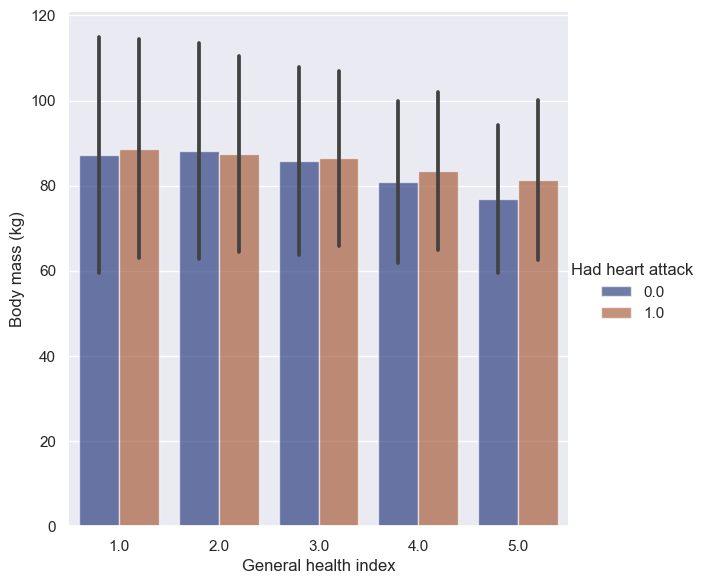

In [78]:
import seaborn as sns
sns.set_theme()
g = sns.catplot(
    data=train, kind="bar",
    x="GeneralHealth", y="WeightInKilograms", hue="HadHeartAttack",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("General health index", "Body mass (kg)")
g.legend.set_title("Had heart attack")

### Osoby palące częsciej miały zawał:

In [79]:
valid.groupby('SmokerStatus', as_index=False)['HadHeartAttack'].mean()

SmokerStatus  HadHeartAttack
0           0.0        0.037162
1           1.0        0.069817
2           2.0        0.082760
3           3.0        0.093980

### Osoby z gorszym wskaźnikiem "GeneralHealth" w tym zbiorze danych częściej miały zawał:

In [80]:
valid.groupby('GeneralHealth', as_index=False)['HadHeartAttack'].mean()

GeneralHealth  HadHeartAttack
0            1.0        0.219401
1            2.0        0.118330
2            3.0        0.056664
3            4.0        0.028686
4            5.0        0.014112

In [81]:
valid.pivot_table('HadHeartAttack',index='GeneralHealth', columns='SmokerStatus')

SmokerStatus        0.0       1.0       2.0       3.0
GeneralHealth                                        
1.0            0.163180  0.242991  0.259740  0.250000
2.0            0.085862  0.120438  0.158195  0.146465
3.0            0.038882  0.059574  0.083070  0.076079
4.0            0.023638  0.022901  0.039315  0.032688
5.0            0.011113  0.017544  0.020365  0.025316

## Normalizacja część 2 - Skalowanie kolumn numerycznych do 0-1

In [82]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
def scale_float_columns(dataset):
    numerical_columns = list(dataset.select_dtypes(include=['float64']).columns)
    dataset[numerical_columns] = scaler.fit_transform(dataset[numerical_columns])

In [83]:
test.head()

State  Male  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
276058    New York   1.0            3.0                 2.0               0.0   
189605    Michigan   0.0            2.0                20.0              15.0   
59234     Delaware   0.0            4.0                 0.0               0.0   
255322  New Mexico   1.0            3.0                 0.0               0.0   
226504     Montana   0.0            4.0                 6.0               0.0   

                                          LastCheckupTime  PhysicalActivities  \
276058  Within past 2 years (1 year but less than 2 ye...                 NaN   
189605  Within past year (anytime less than 12 months ...                 1.0   
59234   Within past year (anytime less than 12 months ...                 1.0   
255322                                5 or more years ago                 1.0   
226504  Within past year (anytime less than 12 months ...                 1.0   

        SleepHours  RemovedTeeth  HadHeartAttack  ...  HeightInMeters  \
276058         7.0           0.0             0.0  ...            1.55   
189605         5.0           3.0             0.0  ...            1.68   
59234          6.0           0.0             0.0  ...            1.50   
255322         6.0           0.0             0.0  ...             NaN   
226504         8.0           0.0             0.0  ...            1.73   

        WeightInKilograms    BMI  AlcoholDrinkers  HIVTesting  FluVaxLast12  \
276058                NaN    NaN              0.0         0.0           0.0   
189605              70.31  25.02              0.0         NaN           1.0   
59234               64.41  28.68              0.0         0.0           1.0   
255322                NaN    NaN              NaN         NaN           NaN   
226504              90.72  30.41              1.0         0.0           0.0   

        PneumoVaxEver  TetanusLast10Tdap  HighRiskLastYear  CovidPos  
276058            NaN                1.0               0.0       0.0  
189605            1.0                NaN               0.0       0.0  
59234             NaN                1.0               0.0       0.0  
255322            NaN                NaN               NaN       NaN  
226504            1.0                NaN               0.0       1.0  

[5 rows x 40 columns]

In [84]:
scale_float_columns(test)
scale_float_columns(train)
scale_float_columns(valid)
test.head()

State  Male  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
276058    New York   1.0           0.50            0.066667               0.0   
189605    Michigan   0.0           0.25            0.666667               0.5   
59234     Delaware   0.0           0.75            0.000000               0.0   
255322  New Mexico   1.0           0.50            0.000000               0.0   
226504     Montana   0.0           0.75            0.200000               0.0   

                                          LastCheckupTime  PhysicalActivities  \
276058  Within past 2 years (1 year but less than 2 ye...                 NaN   
189605  Within past year (anytime less than 12 months ...                 1.0   
59234   Within past year (anytime less than 12 months ...                 1.0   
255322                                5 or more years ago                 1.0   
226504  Within past year (anytime less than 12 months ...                 1.0   

        SleepHours  RemovedTeeth  HadHeartAttack  ...  HeightInMeters  \
276058    0.260870           0.0             0.0  ...        0.474074   
189605    0.173913           1.0             0.0  ...        0.570370   
59234     0.217391           0.0             0.0  ...        0.437037   
255322    0.217391           0.0             0.0  ...             NaN   
226504    0.304348           0.0             0.0  ...        0.607407   

        WeightInKilograms       BMI  AlcoholDrinkers  HIVTesting  \
276058                NaN       NaN              0.0         0.0   
189605           0.187845  0.145127              0.0         NaN   
59234            0.164576  0.188206              0.0         0.0   
255322                NaN       NaN              NaN         NaN   
226504           0.268339  0.208569              1.0         0.0   

        FluVaxLast12  PneumoVaxEver  TetanusLast10Tdap  HighRiskLastYear  \
276058           0.0            NaN                0.0               0.0   
189605           1.0            1.0                NaN               0.0   
59234            1.0            NaN                0.0               0.0   
255322           NaN            NaN                NaN               NaN   
226504           0.0            1.0                NaN               0.0   

        CovidPos  
276058       0.0  
189605       0.0  
59234        0.0  
255322       NaN  
226504       1.0  

[5 rows x 40 columns]

## 5. Czyszczenie brakujących pól

Nie możemy użyć .dropna() gdyż większość wierszy ma brakujące wartości:

In [85]:
print(df.shape[0])
print(df.shape[0] - df.dropna().shape[0])

445132
199110


In [86]:
test.head()

State  Male  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
276058    New York   1.0           0.50            0.066667               0.0   
189605    Michigan   0.0           0.25            0.666667               0.5   
59234     Delaware   0.0           0.75            0.000000               0.0   
255322  New Mexico   1.0           0.50            0.000000               0.0   
226504     Montana   0.0           0.75            0.200000               0.0   

                                          LastCheckupTime  PhysicalActivities  \
276058  Within past 2 years (1 year but less than 2 ye...                 NaN   
189605  Within past year (anytime less than 12 months ...                 1.0   
59234   Within past year (anytime less than 12 months ...                 1.0   
255322                                5 or more years ago                 1.0   
226504  Within past year (anytime less than 12 months ...                 1.0   

        SleepHours  RemovedTeeth  HadHeartAttack  ...  HeightInMeters  \
276058    0.260870           0.0             0.0  ...        0.474074   
189605    0.173913           1.0             0.0  ...        0.570370   
59234     0.217391           0.0             0.0  ...        0.437037   
255322    0.217391           0.0             0.0  ...             NaN   
226504    0.304348           0.0             0.0  ...        0.607407   

        WeightInKilograms       BMI  AlcoholDrinkers  HIVTesting  \
276058                NaN       NaN              0.0         0.0   
189605           0.187845  0.145127              0.0         NaN   
59234            0.164576  0.188206              0.0         0.0   
255322                NaN       NaN              NaN         NaN   
226504           0.268339  0.208569              1.0         0.0   

        FluVaxLast12  PneumoVaxEver  TetanusLast10Tdap  HighRiskLastYear  \
276058           0.0            NaN                0.0               0.0   
189605           1.0            1.0                NaN               0.0   
59234            1.0            NaN                0.0               0.0   
255322           NaN            NaN                NaN               NaN   
226504           0.0            1.0                NaN               0.0   

        CovidPos  
276058       0.0  
189605       0.0  
59234        0.0  
255322       NaN  
226504       1.0  

[5 rows x 40 columns]

Uzupełniam brakujące wartości medianą:

In [87]:
numeric_columns = train.select_dtypes(include=['number']).columns
test[numeric_columns] = test[numeric_columns].fillna(test[numeric_columns].median().iloc[0])
train[numeric_columns] = train[numeric_columns].fillna(train[numeric_columns].median().iloc[0])
valid[numeric_columns] = valid[numeric_columns].fillna(valid[numeric_columns].iloc[0])

In [88]:
test.head()

State  Male  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
276058    New York   1.0           0.50            0.066667               0.0   
189605    Michigan   0.0           0.25            0.666667               0.5   
59234     Delaware   0.0           0.75            0.000000               0.0   
255322  New Mexico   1.0           0.50            0.000000               0.0   
226504     Montana   0.0           0.75            0.200000               0.0   

                                          LastCheckupTime  PhysicalActivities  \
276058  Within past 2 years (1 year but less than 2 ye...                 0.0   
189605  Within past year (anytime less than 12 months ...                 1.0   
59234   Within past year (anytime less than 12 months ...                 1.0   
255322                                5 or more years ago                 1.0   
226504  Within past year (anytime less than 12 months ...                 1.0   

        SleepHours  RemovedTeeth  HadHeartAttack  ...  HeightInMeters  \
276058    0.260870           0.0             0.0  ...        0.474074   
189605    0.173913           1.0             0.0  ...        0.570370   
59234     0.217391           0.0             0.0  ...        0.437037   
255322    0.217391           0.0             0.0  ...        0.000000   
226504    0.304348           0.0             0.0  ...        0.607407   

        WeightInKilograms       BMI  AlcoholDrinkers  HIVTesting  \
276058           0.000000  0.000000              0.0         0.0   
189605           0.187845  0.145127              0.0         0.0   
59234            0.164576  0.188206              0.0         0.0   
255322           0.000000  0.000000              0.0         0.0   
226504           0.268339  0.208569              1.0         0.0   

        FluVaxLast12  PneumoVaxEver  TetanusLast10Tdap  HighRiskLastYear  \
276058           0.0            0.0                0.0               0.0   
189605           1.0            1.0                0.0               0.0   
59234            1.0            0.0                0.0               0.0   
255322           0.0            0.0                0.0               0.0   
226504           0.0            1.0                0.0               0.0   

        CovidPos  
276058       0.0  
189605       0.0  
59234        0.0  
255322       0.0  
226504       1.0  

[5 rows x 40 columns]

Kolumny kategoryczne wypełniłem w czasie normalizacji wartościami "Unknown" ponieważ fillna-->median nie działa dla tego typu danych
(https://stackoverflow.com/questions/49127897/python-pandas-fillna-median-not-working)

In [89]:
test["HighRiskLastYear"].value_counts()

HighRiskLastYear
0.0    42810
1.0     1703
Name: count, dtype: int64

In [90]:
test["HighRiskLastYear"].isna().sum()

0

### Brak wartości non-null:

In [91]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44513 entries, 276058 to 196692
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   State                      44513 non-null  category
 1   Male                       44513 non-null  float64 
 2   GeneralHealth              44513 non-null  float64 
 3   PhysicalHealthDays         44513 non-null  float64 
 4   MentalHealthDays           44513 non-null  float64 
 5   LastCheckupTime            44513 non-null  category
 6   PhysicalActivities         44513 non-null  float64 
 7   SleepHours                 44513 non-null  float64 
 8   RemovedTeeth               44513 non-null  float64 
 9   HadHeartAttack             44513 non-null  float64 
 10  HadAngina                  44513 non-null  float64 
 11  HadStroke                  44513 non-null  float64 
 12  HadAsthma                  44513 non-null  float64 
 13  HadSkinCancer              445

In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676617 entries, 0 to 676616
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   State                      676617 non-null  category
 1   Male                       676617 non-null  float64 
 2   GeneralHealth              676617 non-null  float64 
 3   PhysicalHealthDays         676617 non-null  float64 
 4   MentalHealthDays           676617 non-null  float64 
 5   LastCheckupTime            676617 non-null  category
 6   PhysicalActivities         676617 non-null  float64 
 7   SleepHours                 676617 non-null  float64 
 8   RemovedTeeth               676617 non-null  float64 
 9   HadHeartAttack             676617 non-null  float64 
 10  HadAngina                  676617 non-null  float64 
 11  HadStroke                  676617 non-null  float64 
 12  HadAsthma                  676617 non-null  float64 
 13  HadSkinCancer 

In [93]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44514 entries, 127295 to 418173
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   State                      44514 non-null  category
 1   Male                       44514 non-null  float64 
 2   GeneralHealth              44514 non-null  float64 
 3   PhysicalHealthDays         44514 non-null  float64 
 4   MentalHealthDays           44514 non-null  float64 
 5   LastCheckupTime            44514 non-null  category
 6   PhysicalActivities         44514 non-null  float64 
 7   SleepHours                 44514 non-null  float64 
 8   RemovedTeeth               44514 non-null  float64 
 9   HadHeartAttack             44514 non-null  float64 
 10  HadAngina                  44514 non-null  float64 
 11  HadStroke                  44514 non-null  float64 
 12  HadAsthma                  44514 non-null  float64 
 13  HadSkinCancer              445

### Zapisywanie do csv

In [94]:
cat_columns = test.select_dtypes(['category']).columns
print(cat_columns)

Index(['State', 'LastCheckupTime', 'RaceEthnicityCategory', 'AgeCategory'], dtype='object')


In [95]:
#test[cat_columns] = test[cat_columns].apply(lambda x: pd.factorize(x)[0])
#train[cat_columns] = train[cat_columns].apply(lambda x: pd.factorize(x)[0])
#valid[cat_columns] = valid[cat_columns].apply(lambda x: pd.factorize(x)[0])

In [96]:
test.to_csv("test.csv")
train.to_csv("train.csv")
valid.to_csv("valid.csv")